<center><h1>Graph Analysis</h1></center>

# 1. Information

Я использовал свой аккаунт ВКонтакте для сбора данных. Имена моих друзей я не изменял, так что рассчитываю на конфиденциальность.
Я собрал данные по своим друзьям и друзьям друзей. Выгружать все контакты я не стал. Их слишком много, да и ВК дает отсечку, если отправить слишком много запросов.

# 2. Data Import

## 2.1 Import packages

In [1]:
import time
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
import warnings
import json

import vk_api

import networkx as nx
from networkx.readwrite import json_graph
from collections import Counter

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

## 2.2 Data Parsing

In [2]:
def auth_handler():
    """ При двухфакторной аутентификации вызывается эта функция.
    """

    # Код двухфакторной аутентификации
    key = input("Enter authentication code: ")
    # Если: True - сохранить, False - не сохранять.
    remember_device = True

    return key, remember_device

In [3]:
vk_session = vk_api.VkApi(login        = 'lightoff@mail.ru',#'veravlade@mail.ru',#'lightoff@mail.ru',
                          password     = 'tyrgor2020!',#'solodkaya7',#'tyrgor2020!',
                          auth_handler = auth_handler)
vk_session.auth(token_only=True)

vk = vk_session.get_api()

In [4]:
def get_frends(user_id=''):
    return vk.friends.get( user_id = user_id,
                    fields = ['nickname'])['items']

In [11]:
def set_friend_graph (friends_num = -1):
    friends_num=5
    g = nx.Graph(directed=True)
    print("Get initial user friends IDs:")
    friends_dict = dict()
    for i in tqdm_notebook(get_frends()):
        try:
            friends_dict[i['id']] = get_frends(str(i['id']))
        except:
            continue
            
    print("Get IDs of frinds:")
    
    if (friends_num <= 0 ):
        id_list = list(friends_dict.keys())
    else:
        id_list = list(friends_dict.keys())[0:friends_num]
    
    # Берем каждого друга из словаря
    for i in ({k: friends_dict[k] for k in id_list}):
        g.add_node(i)
        # Берем друга друга из словаря
        for j in (friends_dict[i]):
            if i != j['id']:
                try:
                    #sec_user_dict = {j['id'] : vk.users.get(user_id = j['id'], fields = ['nickname'])[0]}
                    #if (sec_user_dict[j['id']]['first_name'] == 'DELETED'):
                    #    continue
                    g.add_edge(i, j['id'])
                    nx.set_node_attributes(g, {j['id']:j})
                except:
                    continue
    nx.set_node_attributes(g, {i['id']:i for i in get_frends()})
    return g

In [12]:
def write_friend_graph(graph):
    jdata = json_graph.node_link_data(graph)
    with open('graph.json', 'w') as f:
        json.dump(jdata, f)
        return True
    return False

In [13]:
def read_friend_graph(file_name):
    with open(file_name) as json_file:
        data = json.load(json_file)
    data['directed'] = True
    data['multigraph'] = False
    data['graph'] = {}
    graph = json_graph.node_link_graph(data)
    return graph

In [14]:
g = set_friend_graph(5)

Get initial user friends IDs:



Get IDs of frinds:


In [15]:
g.number_of_nodes()

1491

In [16]:
g.number_of_edges()

1542

In [17]:
#g.nodes.data()

In [18]:
write_friend_graph(g)

True

# 3. Plot Graph 

## 3.1 Initial Graph Plot

In [19]:
G=read_friend_graph('graph.json')

In [20]:
def plt_graph(graph):
    labels={n[0]: str(n[1]['first_name']) + ' ' + str(n[1]['last_name']) for n in graph.nodes.data()}
    plt.figure(figsize=(10, 20))
    nx.draw_random(graph, with_labels=True, alpha=0.7, node_size=60,font_size=8, labels=labels)

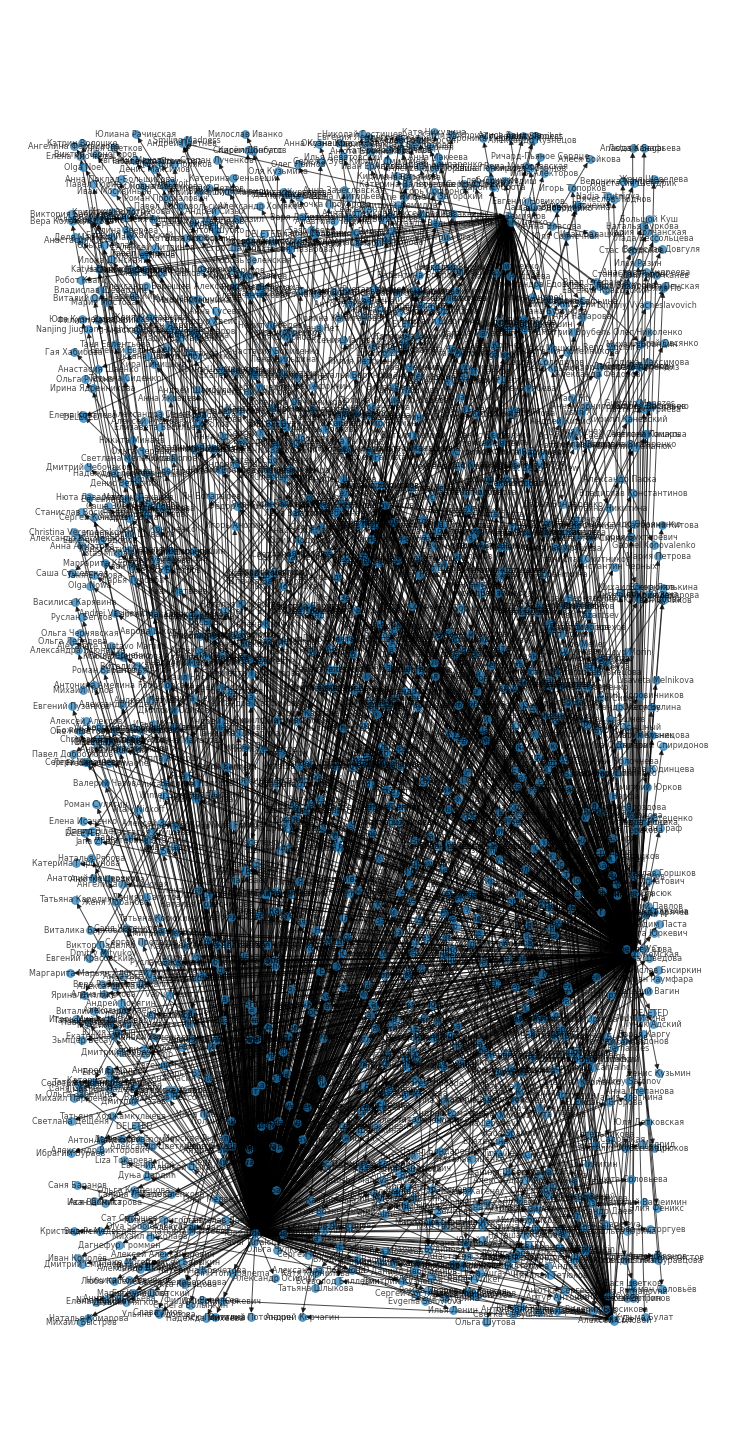

In [21]:
plt_graph(G)

## 3.2 Betweenness centrality Plot

In [22]:
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_centrality_counts = Counter(betweenness_centrality)
for k, v in betweenness_centrality_counts.most_common(10):
    print((str(G.nodes[k]['first_name']) + ' ' + str(G.nodes[k]['last_name'])), v)

Виолетта Лукомская 0.0037861543939673938
Алексей Гущин 0.0033228012133723365
Юрий Лебедов 0.0031555793943054433
Кирилл Земляков 0.0029401291799820606
Андрей Мухин 0.0011556785554919522
Илья Бураков 0.000333992905467838
Виктор Фомичёв 0.0001805935548233654
Руслан Баскаков 0.0001805935548233654
Мила Борисова 0.0001805935548233654
Лешка Да 0.0


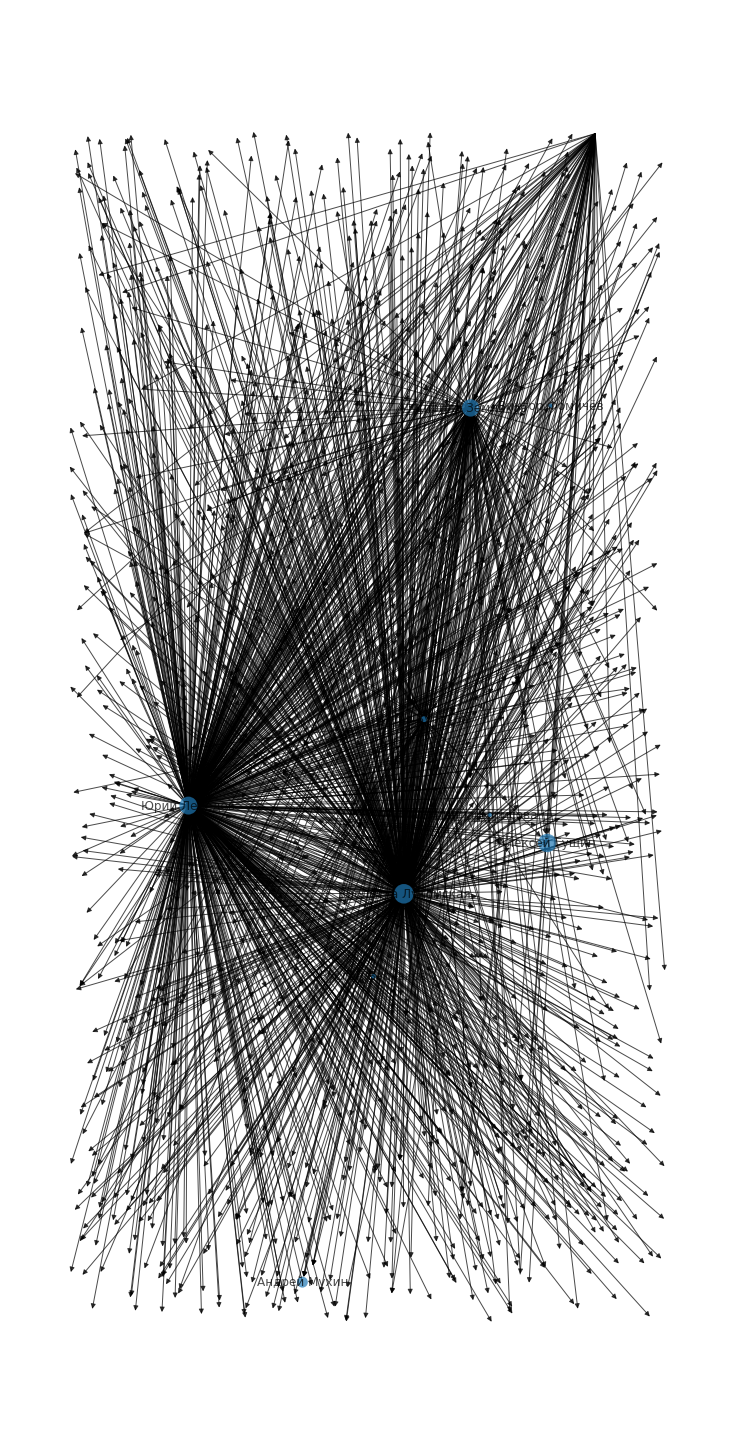

In [23]:
plt.figure(figsize=(10, 20))
th = betweenness_centrality_counts.most_common(20)[-1][1]
nx.draw_random(
    G, 
    with_labels=True, 
    alpha=0.7, 
    labels={n[0]:str(n[1]['first_name']) + ' ' + str(n[1]['last_name']) for n in G.nodes.data() if betweenness_centrality[n[0]] > th}, 
    node_size=np.array(list(betweenness_centrality.values())) * 100000,
    linewidths=0.1,
)

## 3.3  Degree centrality Plot

In [24]:
degree_centrality = nx.degree_centrality(G)
degree_centrality_counts = Counter(degree_centrality)
for k, v in degree_centrality_counts.most_common(10):
    print((str(G.nodes[k]['first_name']) + ' ' + str(G.nodes[k]['last_name'])), v)

Юрий Лебедов 0.4308724832214765
Виолетта Лукомская 0.4053691275167785
Кирилл Земляков 0.09932885906040267
Илья Бураков 0.05100671140939597
Лешка Да 0.050335570469798654
Алексей Гущин 0.003355704697986577
Андрей Мухин 0.0026845637583892616
Дмитрий Демидов 0.002013422818791946
Андрей Билиньков 0.002013422818791946
Дмитрий Павлов 0.002013422818791946


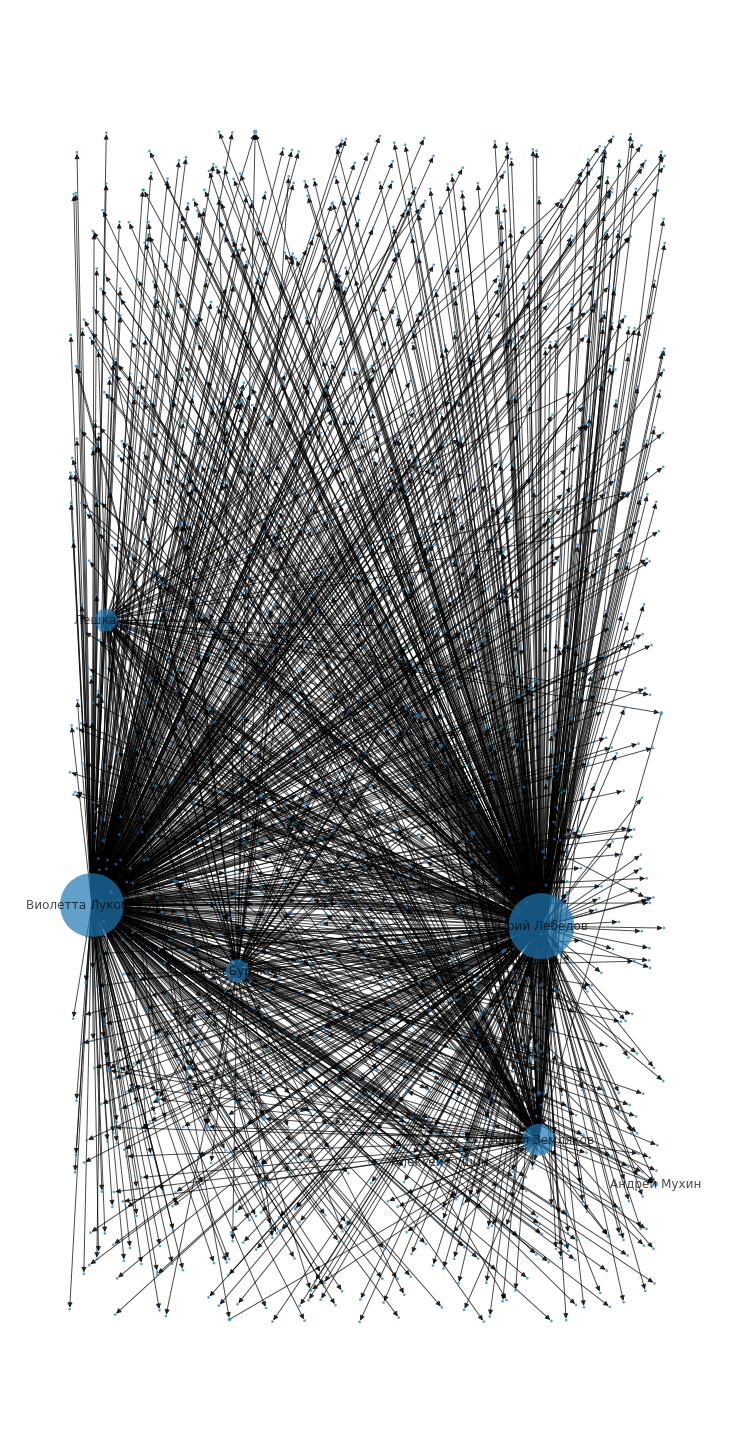

In [25]:
th = degree_centrality_counts.most_common(20)[-1][1]
plt.figure(figsize=(10, 20))
nx.draw_random(
    G, 
    with_labels=True, 
    alpha=0.7, 
    labels={n[0]:str(n[1]['first_name']) + ' ' + str(n[1]['last_name']) for n in G.nodes.data() if degree_centrality[n[0]] > th}, 
    node_size=np.array(list(degree_centrality.values())) * 10000,
    linewidths=0.1,
)

## 3.4 Closeness centrality Plot

In [26]:
closeness_centrality = nx.closeness_centrality(G)
closeness_centrality_counts = Counter(closeness_centrality)
for k, v in closeness_centrality_counts.most_common(10):
    print((str(G.nodes[k]['first_name']) + ' ' + str(G.nodes[k]['last_name'])), v)

Кирилл Земляков 0.004697986577181208
Виолетта Лукомская 0.0043847874720357935
Михаил Рыбасов 0.0033557046979865767
Антон Майский 0.0033557046979865767
Денис Игнатович 0.0033557046979865767
Наташа Кутасова 0.0033557046979865767
Аня Пак 0.0033557046979865767
Егор Лукомский 0.0033557046979865767
Дмитрий Носов 0.0033557046979865767
Вячеслав Лялькин 0.0033557046979865767


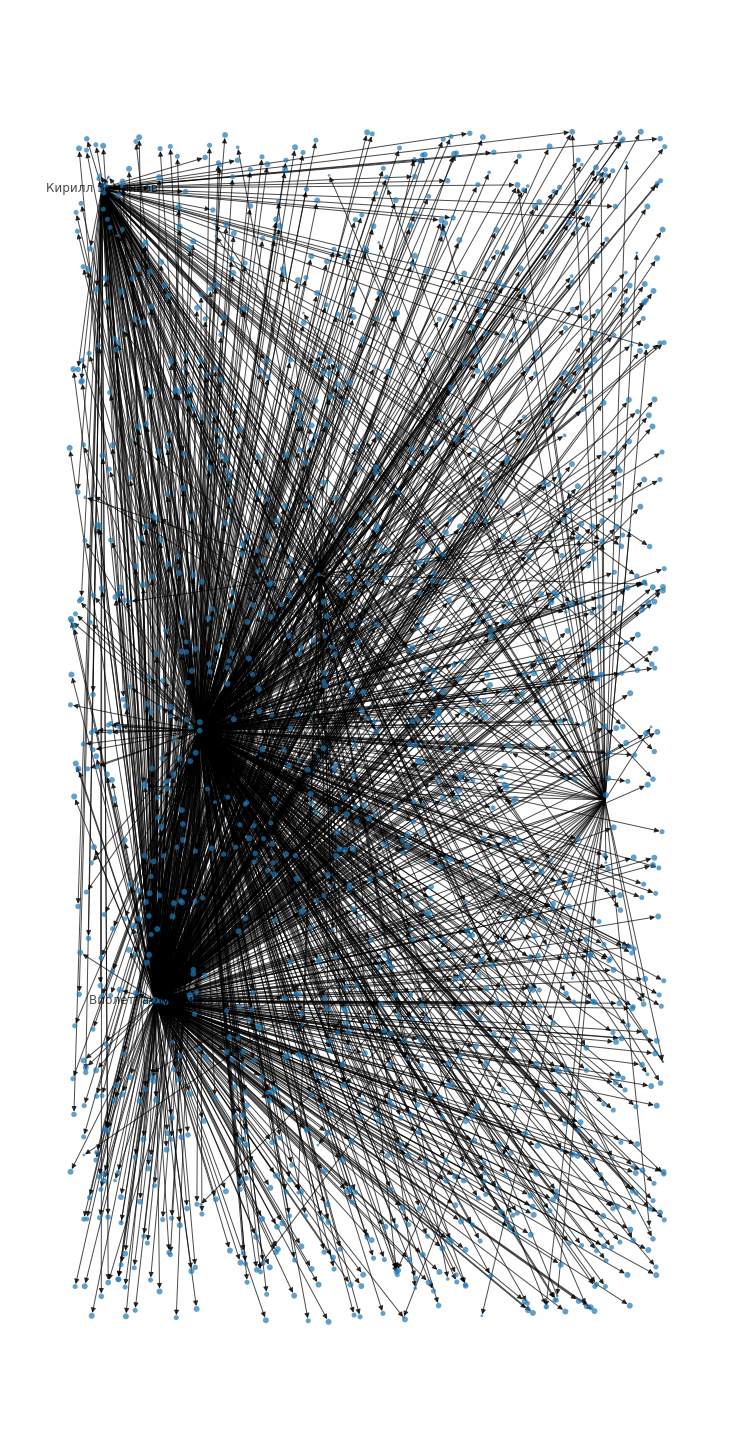

In [28]:
th = closeness_centrality_counts.most_common(20)[-1][1]
plt.figure(figsize=(10, 20))
nx.draw_random(
    G, 
    with_labels=True, 
    alpha=0.7, 
    labels={n[0]:str(n[1]['first_name']) + ' ' + str(n[1]['last_name']) for n in G.nodes.data() if closeness_centrality[n[0]] > th}, 
    node_size=np.array(list(closeness_centrality.values())) * 10000,
    linewidths=0.1,
)

## 3.5 Cliques Find

In [49]:
cliques = nx.find_cliques(G.to_undirected())
first_elem = 10
for c in cliques:
    if (len(c)>3):
        print(c, ', '.join([str(G.nodes[n]['first_name'])+' '+(G.nodes[n]['last_name']) for n in c]))

    

[20561, 5200, 17360, 8745] Владимир Горбунов, Лешка Да, Кирилл Земляков, Илья Бураков
[4422, 5200, 17360, 8745] Дмитрий Демидов, Лешка Да, Кирилл Земляков, Илья Бураков
[72113, 5200, 17360, 8745] Андрей Альтмарк, Лешка Да, Кирилл Земляков, Илья Бураков
[8745, 17360, 5200, 144928] Илья Бураков, Кирилл Земляков, Лешка Да, Андрей Гаврилин
[8745, 17360, 5200, 684769] Илья Бураков, Кирилл Земляков, Лешка Да, Андрей Плетнёв
[8745, 17360, 5200, 73152] Илья Бураков, Кирилл Земляков, Лешка Да, Андрей Мухин
[8745, 17360, 5200, 20323] Илья Бураков, Кирилл Земляков, Лешка Да, Дмитрий Павлов
[8745, 17360, 5200, 61029] Илья Бураков, Кирилл Земляков, Лешка Да, Ярослав Саламаха
[8745, 17360, 5200, 19336] Илья Бураков, Кирилл Земляков, Лешка Да, Андрей Билиньков
[8745, 17360, 5200, 1801800] Илья Бураков, Кирилл Земляков, Лешка Да, Алексей Гущин
[8745, 17360, 5200, 332587] Илья Бураков, Кирилл Земляков, Лешка Да, Денис Астрелин
[8745, 17360, 5200, 1596268] Илья Бураков, Кирилл Земляков, Лешка Да, Марина

# 4 Conclusion

Действительно метрики довольно точно работают. 
Сильно вдаваться в подробности я не буду, но как правило наибольшие значения метрик имеют мои одноклассники и одноклубники. Особенно это хорошо видно при поиске клик)